In [2]:
!pip install -q sklearn
!pip install -q pandas

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.display import clear_output
from six.moves import urllib

In [4]:
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

In [5]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [6]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [7]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [9]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

<AxesSubplot:>

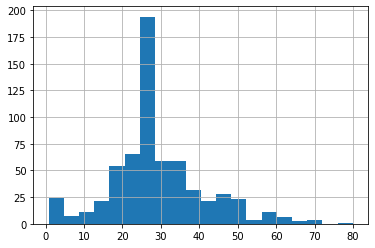

In [8]:
dftrain.age.hist(bins=20)

<AxesSubplot:>

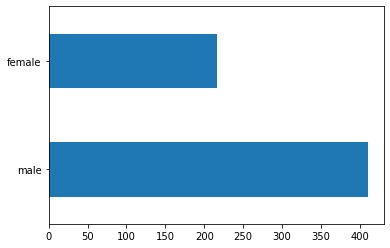

In [10]:
dftrain.sex.value_counts().plot(kind='barh')

<AxesSubplot:>

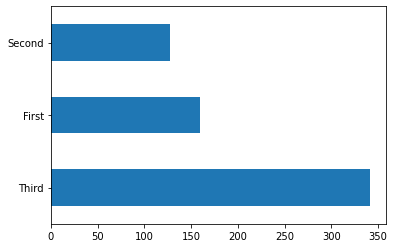

In [11]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

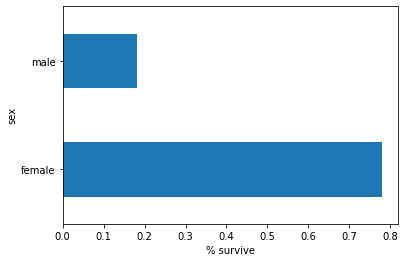

In [12]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

estimator는 feature columns 이라는 시스템을 사용하여 모델이 각각의 입력 feature를 어떻게 해석할지 설명합니다.

In [13]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [18]:
print(*feature_columns, sep='\n')

VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, default_va

In [19]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [21]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('특성 키:', list(feature_batch.keys()))
    print()
    print('클래스 배치:', feature_batch['class'].numpy())
    print()
    print('레이블 배치:', label_batch.numpy())

특성 키: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

클래스 배치: [b'Third' b'Third' b'Second' b'Second' b'First' b'Third' b'Third' b'Third'
 b'Third' b'Second']

레이블 배치: [0 1 1 1 1 1 1 1 0 1]


In [24]:
feature_batch

{'sex': <tf.Tensor: shape=(10,), dtype=string, numpy=
 array([b'male', b'female', b'female', b'female', b'male', b'female',
        b'male', b'female', b'male', b'female'], dtype=object)>,
 'age': <tf.Tensor: shape=(10,), dtype=float64, numpy=array([28. , 28. , 32.5, 40. , 48. , 28. , 39. , 28. , 28. , 28. ])>,
 'n_siblings_spouses': <tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>,
 'parch': <tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>,
 'fare': <tf.Tensor: shape=(10,), dtype=float64, numpy=
 array([ 7.8958,  7.8792, 13.    , 13.    , 26.55  ,  7.8792,  7.925 ,
         7.7333,  7.225 , 12.35  ])>,
 'class': <tf.Tensor: shape=(10,), dtype=string, numpy=
 array([b'Third', b'Third', b'Second', b'Second', b'First', b'Third',
        b'Third', b'Third', b'Third', b'Second'], dtype=object)>,
 'deck': <tf.Tensor: shape=(10,), dtype=string, numpy=
 array([b'unknown', b'unknown', b'E', b'unknown', b'E', b'unknown',
      

또한 ```tf.keras.layers.DenseFeatures``` 층을 사용하여 특정한 특성 열의 결과를 점검할 수 있습니다.

In [23]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[28. ],
       [28. ],
       [32.5],
       [40. ],
       [48. ],
       [28. ],
       [39. ],
       [28. ],
       [28. ],
       [28. ]], dtype=float32)

```DenseFeatures```는 조밀한(dense) 텐서만 허용합니다. 범주형 데이터를 점검하려면 우선 범주형 열에 indicator_column 함수를 적용해야 합니다.

In [25]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [27]:
tf.estimator.LinearClassifier??

In [26]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()  # Clear the output of the current cell receiving output.

print(result)

{'accuracy': 0.75757575, 'accuracy_baseline': 0.625, 'auc': 0.828191, 'auc_precision_recall': 0.7980784, 'average_loss': 0.47764245, 'label/mean': 0.375, 'loss': 0.469616, 'precision': 0.68817204, 'prediction/mean': 0.39543387, 'recall': 0.64646465, 'global_step': 200}


In [30]:
clear_output??

서로 다른 feature 조합들 간의 차이를 학습하기 위해서 모델에 교차 특성 열을 추가할 수 있습니다.

ex. (Male, 30), (Male, 40) 을 구별하는 것

In [31]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

In [32]:
age_x_gender

CrossedColumn(keys=('age', 'sex'), hash_bucket_size=100, hash_key=None)

In [33]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.75, 'accuracy_baseline': 0.625, 'auc': 0.8392103, 'auc_precision_recall': 0.7687011, 'average_loss': 0.49468353, 'label/mean': 0.375, 'loss': 0.4910226, 'precision': 0.64102566, 'prediction/mean': 0.440621, 'recall': 0.75757575, 'global_step': 200}


In [38]:
list(pred_dicts)

[{'logits': array([-1.9655449], dtype=float32),
  'logistic': array([0.12286821], dtype=float32),
  'probabilities': array([0.8771318 , 0.12286821], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([0.48223522], dtype=float32),
  'logistic': array([0.6182755], dtype=float32),
  'probabilities': array([0.38172445, 0.6182755 ], dtype=float32),
  'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([1.4106424], dtype=float32),
  'logistic': array([0.8038673], dtype=float32),
  'probabilities': array([0.19613276, 0.8038673 ], dtype=float32),
  'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpscds20ed/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<AxesSubplot:title={'center':'예측 확률'}, ylabel='Frequency'>

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_te

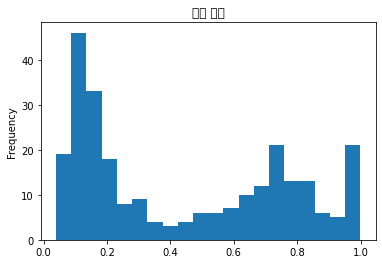

In [36]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='예측 확률')

수신자 조작 특성(receiver operating characteristic, ROC)을 살펴보면 정탐률(true positive rate)과 오탐률(false positive rate)의 상충관계에 대해 더 잘 이해할 수 있습니다.

(0.0, 1.05)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 53456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 53456 missing from current font.
  font.set_te

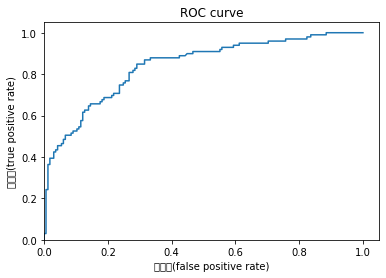

In [39]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('오탐률(false positive rate)')
plt.ylabel('정탐률(true positive rate)')
plt.xlim(0,)
plt.ylim(0,)